In [1]:
import os
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scprep
import numpy as np
from pyplink import PyPlink
import tqdm
import phate
from sklearn.decomposition import PCA

os.chdir('../../src')
import mappings
import data_loader

In [2]:
# Load HGDP
exp_path = '/lustre06/project/6065672/shared/MattDataSharing/1KGP+HGDP/V4'
fname = 'gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnet'
data_path = os.path.join(exp_path, fname)

pedfile = PyPlink(data_path)

In [3]:
all_samples = pedfile.get_fam()
all_samples.head()

,fid,iid,father,mother,gender,status
0,CHMI_CHMI3_WGS2,CHMI_CHMI3_WGS2,0,0,0,-9
1,HG00096,HG00096,0,0,0,-9
2,HG00097,HG00097,0,0,0,-9
3,HG00099,HG00099,0,0,0,-9
4,HG00100,HG00100,0,0,0,-9


In [4]:
all_markers = pedfile.get_bim()
all_markers.head()

,chrom,pos,cm,a1,a2
snp,,,,,
1:858952:G:A,1,858952,0,A,G
1:905373:T:C,1,905373,0,C,T
1:911428:C:T,1,911428,0,T,C
1:918870:A:G,1,918870,0,G,A
1:931513:T:C,1,931513,0,C,T


In [5]:
try:
    genotypes_array = np.load(exp_path + '_raw_genotypes.npy')
except:
    genotypes_array = np.zeros([pedfile.get_nb_samples(), pedfile.get_nb_markers()], dtype=np.int8)

    for i, (marker_id, genotypes) in tqdm.tqdm(enumerate(pedfile)):
        genotypes_array[:,i] = genotypes

    np.save(exp_path + '_raw_genotypes.npy', genotypes_array)

In [6]:
genotypes_array = genotypes_array[1:] # remove first row

In [8]:
import numpy as np
from tqdm import tqdm

def compute_modified_grm(genotype_matrix):
    # Initialize the GRM
    n_samples = genotype_matrix.shape[0]
    grm = np.zeros((n_samples, n_samples))
    
    # Compute allele frequencies, ignoring NaNs
    allele_freqs = np.nanmean(genotype_matrix / 2, axis=0)
    
    # Iterate over pairs of samples with tqdm progress bar
    for i in tqdm(range(n_samples), desc="Computing GRM", unit="sample"):
        for j in range(i, n_samples):
            common_variants = ~np.isnan(genotype_matrix[i]) & ~np.isnan(genotype_matrix[j])
            if np.sum(common_variants) > 0:
                # Compute the sum over non-missing variants
                numerator = np.sum(
                    ((genotype_matrix[i, common_variants] - 2 * allele_freqs[common_variants]) *
                     (genotype_matrix[j, common_variants] - 2 * allele_freqs[common_variants])) /
                    (2 * allele_freqs[common_variants] * (1 - allele_freqs[common_variants]))
                )
                # Normalization by the number of non-missing common variants
                grm[i, j] = numerator / np.sum(common_variants)
                grm[j, i] = grm[i, j]  # Symmetric matrix
    
    return grm

# Usage example:
# Assuming genotype_matrix is your NumPy array with NaNs for missing values
grm = compute_modified_grm(genotypes_array)

# Perform eigenvalue decomposition on the GRM to get PCA components
eigenvalues, eigenvectors = np.linalg.eigh(grm)
# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# The principal components are the eigenvectors
pca_components = eigenvectors

Computing GRM:   0%|          | 5/4150 [01:28<20:26:49, 17.76s/sample]


KeyboardInterrupt: 

In [7]:
# HWE Normalization. See the following:
# https://discuss.hail.is/t/understanding-how-hwe-normalized-pca-works/3773/2
# https://hail.is/docs/0.2/methods/genetics.html#hail.methods.hwe_normalized_pca
# https://hail.is/docs/0.2/_modules/hail/methods/pca.html
# https://hail.is/docs/0.2/methods/stats.html#hail.methods.pca

def hwe_normalization_with_imputation(genotype_matrix):
    # Calculate allele frequency for each SNP, ignoring NaNs
    allele_freqs = np.nanmean(genotype_matrix / 2, axis=0)  # p = mean allele frequency

    # Impute missing values (NaNs) with the expected mean genotype (2p)
    imputed_matrix = np.where(np.isnan(genotype_matrix), 2 * allele_freqs, genotype_matrix)

    # Calculate HWE variance
    hwe_variance = 2 * allele_freqs * (1 - allele_freqs)

    # Prevent division by zero in case of SNPs with no variation
    hwe_variance[hwe_variance == 0] = 1

    # Normalize using Hardy-Weinberg variance
    normalized_matrix = (imputed_matrix - 2 * allele_freqs) / np.sqrt(hwe_variance)

    return normalized_matrix

def replace_negative_one_with_nan(array):
    # Replace all occurrences of -1 with np.nan
    array = np.where(array == -1, np.nan, array)
    return array

In [9]:
genotypes_array = replace_negative_one_with_nan(genotypes_array)
genotypes_array = hwe_normalization_with_imputation(genotypes_array)

In [10]:
labels = pd.read_csv(os.path.join(exp_path, 'gnomad.genomes.v3.1.2.hgdp_1kg_subset_sample_meta.reduced.tsv'), sep='\t')
labels = labels[1:] # remove first row

In [11]:
# Load filter data
filter_info = pd.read_csv(os.path.join(exp_path, '4.3/gnomad_derived_metadata_with_filtered_sampleids.csv'), sep=',', index_col=1)

In [12]:
merged_metadata = labels.set_index('sample').merge(filter_info, left_index=True, right_index=True)

In [13]:
def make_palette_label_order_HGDP(populations, superpopulations):
    # SAS -> CSA + add MID, OCE
    pop_palette_hgdp_coarse = copy.deepcopy(mappings.pop_pallette_1000G_coarse)
    pop_palette_hgdp_coarse['CSA'] = mappings.pop_pallette_1000G_coarse['SAS']
    pop_palette_hgdp_coarse.pop('SAS')

    pop_palette_hgdp_coarse['MID'] = 'grey'
    pop_palette_hgdp_coarse['OCE'] = 'yellow'

    label_order_hgdp_coarse = copy.deepcopy(mappings.label_order_1000G_coarse)
    label_order_hgdp_coarse.remove('SAS')
    label_order_hgdp_coarse += ['CSA', 'MID', 'OCE']

    # Keep original 24/26 populations (with colors), and add new ones. New pops colored using superpop
    label_order_hgdp_fine = []
    for super_pop in np.unique(superpopulations):
        for pop in np.unique(populations[superpopulations==super_pop]):
            label_order_hgdp_fine.append(pop)

    # create tmp object to hold the original 26 populations
    mapping_26 = copy.deepcopy(mappings.pop_pallette_1000G_fine)
    mapping_26['GBR'] = mapping_26['CEUGBR']
    mapping_26['CEU'] = mapping_26['CEUGBR']
    mapping_26['STU'] = mapping_26['STUITU']
    mapping_26['ITU'] = mapping_26['STUITU']

    pop_palette_hgdp_fine = {}

    for super_pop in np.unique(superpopulations):
        for pop in np.unique(populations[superpopulations==super_pop]):
            if pop not in mapping_26.keys():
                # just use superpop color for now
                pop_palette_hgdp_fine[pop] = pop_palette_hgdp_coarse[super_pop]
            else:
                pop_palette_hgdp_fine[pop] = mapping_26[pop]

    return pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine

pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine = make_palette_label_order_HGDP(merged_metadata['Population'],
                                                                                                                               merged_metadata['Genetic_region'])

In [14]:
def compute_pca_phate_subset(filtered_indices, related_indices, phate_fit_related=True):
    # Fit PCA model
    NUM_PCS = 50
    pca_obj = PCA(n_components=NUM_PCS)  # Number of components to keep
    pca_obj.fit(genotypes_array[filtered_indices & related_indices]) # dont fit on related individuals

    # Keep the same shape. Non-fitted entries are just 0
    pca_input = np.zeros(shape=(len(genotypes_array), NUM_PCS))
    _pca_input = pca_obj.transform(genotypes_array[filtered_indices])
    pca_input[filtered_indices] = _pca_input

    phate_operator = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
    if phate_fit_related:
        phate_operator.fit(pca_input[filtered_indices])
    else:
        phate_operator.fit(pca_input[filtered_indices & related_indices])
    phate_emb = phate_operator.transform(pca_input[filtered_indices])

    fig, ax = plt.subplots(figsize=(20, 10), ncols=2, gridspec_kw={'wspace': 0.08})

    # PCA
    scprep.plot.scatter2d(pca_input[filtered_indices,:2], 
                          s=20, 
                          cmap=pop_palette_hgdp_fine, ax=ax[0],
                          c=merged_metadata[filtered_indices]['Population'].values, 
                          xticks=False, 
                          yticks=False,
                          legend=True, 
                          legend_loc='lower center', 
                          legend_anchor=(0.5, -0.35), 
                          legend_ncol=8,
                          label_prefix="PCA ", 
                          fontsize=8)
    ax[0].set_title("PCA of HGDP", fontsize=30)
    ax[0].get_legend().remove()

    scprep.plot.scatter2d(phate_emb, 
                          s=20, 
                          cmap=pop_palette_hgdp_fine, ax=ax[1],
                          c=merged_metadata[filtered_indices]['Population'].values, 
                          xticks=False, 
                          yticks=False,
                          legend=True, 
                          legend_loc='lower center', 
                          legend_anchor=(0.5, -0.35), 
                          legend_ncol=8,
                          label_prefix="PHATE ", 
                          fontsize=8)

    ax[1].set_title("PHATE of HGDP", fontsize=30)

## Keep all Points

Running PHATE on 4150 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.43 seconds.
  Calculating affinities...
  Calculated affinities in 0.05 seconds.
Calculated graph and diffusion operator in 0.51 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.19 seconds.
  Calculating KMeans...
  Calculated KMeans in 5.28 seconds.
Calculated landmark operator in 6.19 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.96 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.00 seconds.


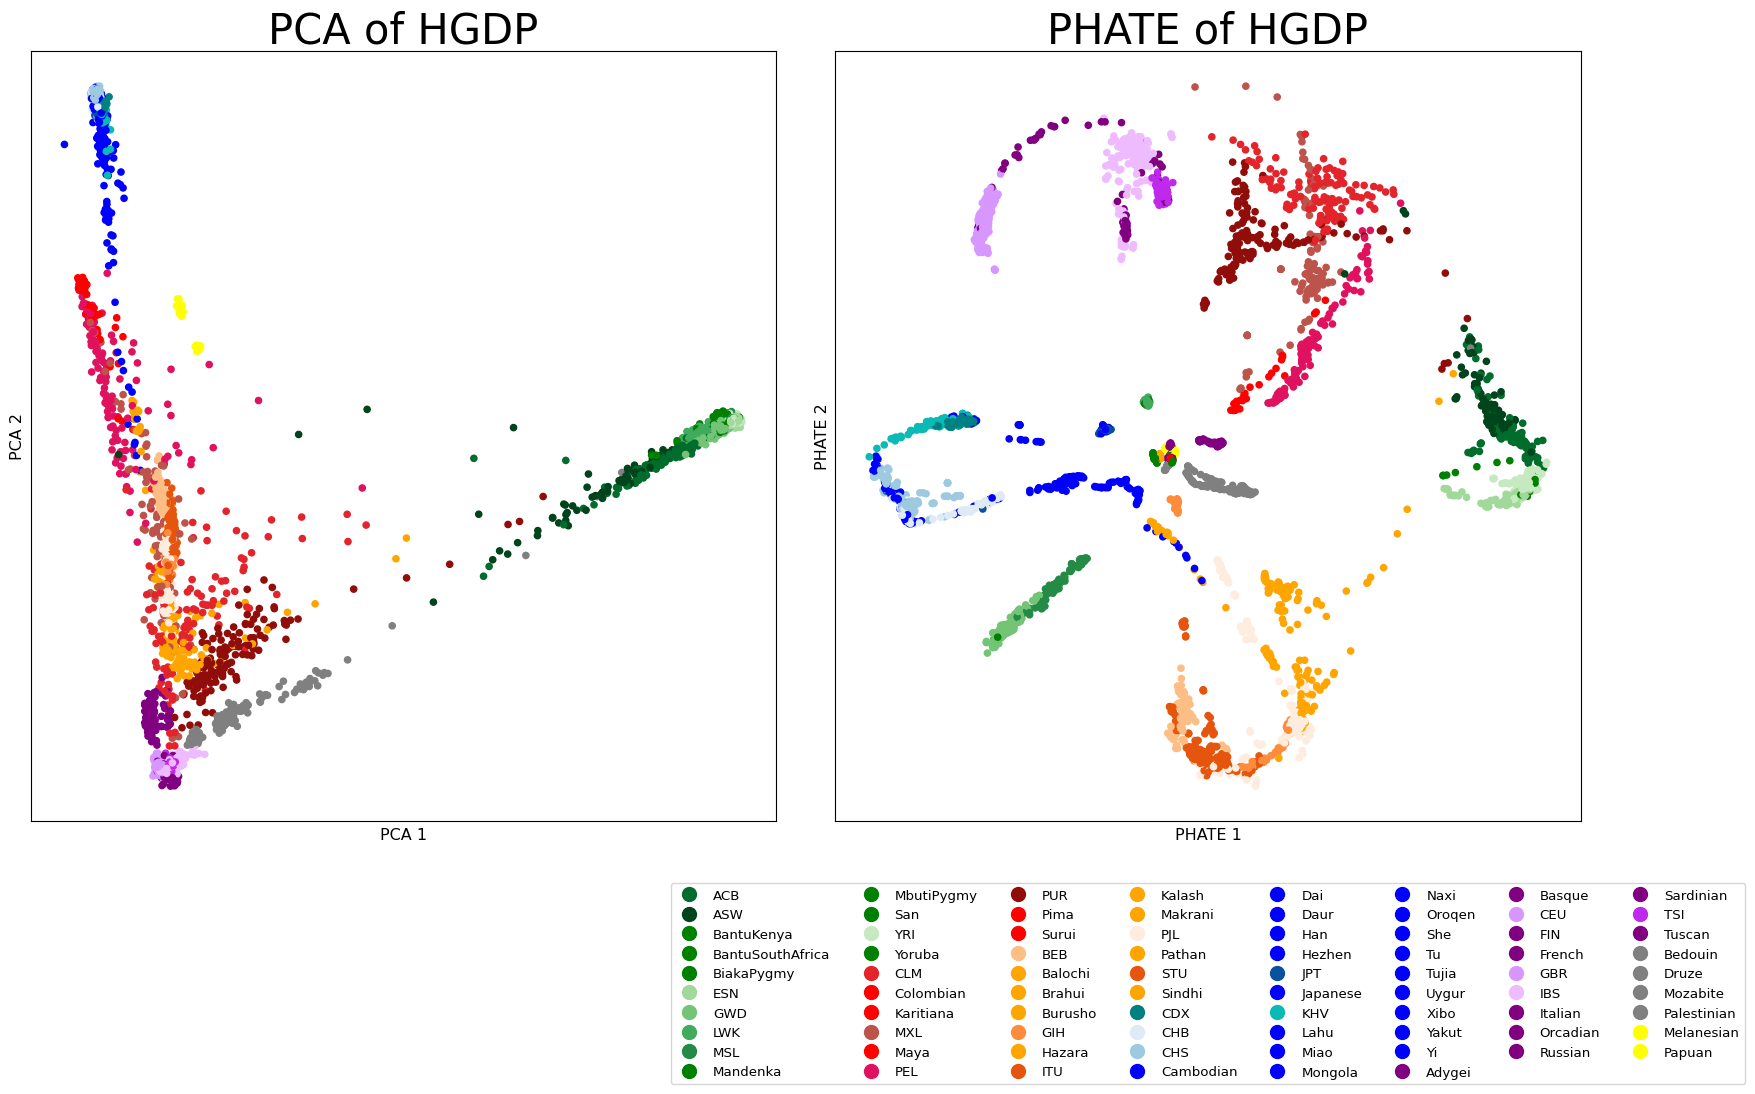

In [15]:
filtered_indices = related_indices = np.ones(shape=genotypes_array.shape[0], dtype=bool)
compute_pca_phate_subset(filtered_indices, related_indices, phate_fit_related=True)

## Includes Relatedness, but removes filtered points

In [16]:
filters = ["filter_pca_outlier", "hard_filtered", "filter_contaminated"]
_filtered_indices = merged_metadata[merged_metadata[filters].any(axis=1)].index
filtered_indices = ~merged_metadata.index.isin(_filtered_indices)
related_indices = np.ones(shape=genotypes_array.shape[0], dtype=bool)

Running PHATE on 4094 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.40 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.44 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.19 seconds.
  Calculating KMeans...
  Calculated KMeans in 3.68 seconds.
Calculated landmark operator in 4.69 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.95 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.04 seconds.


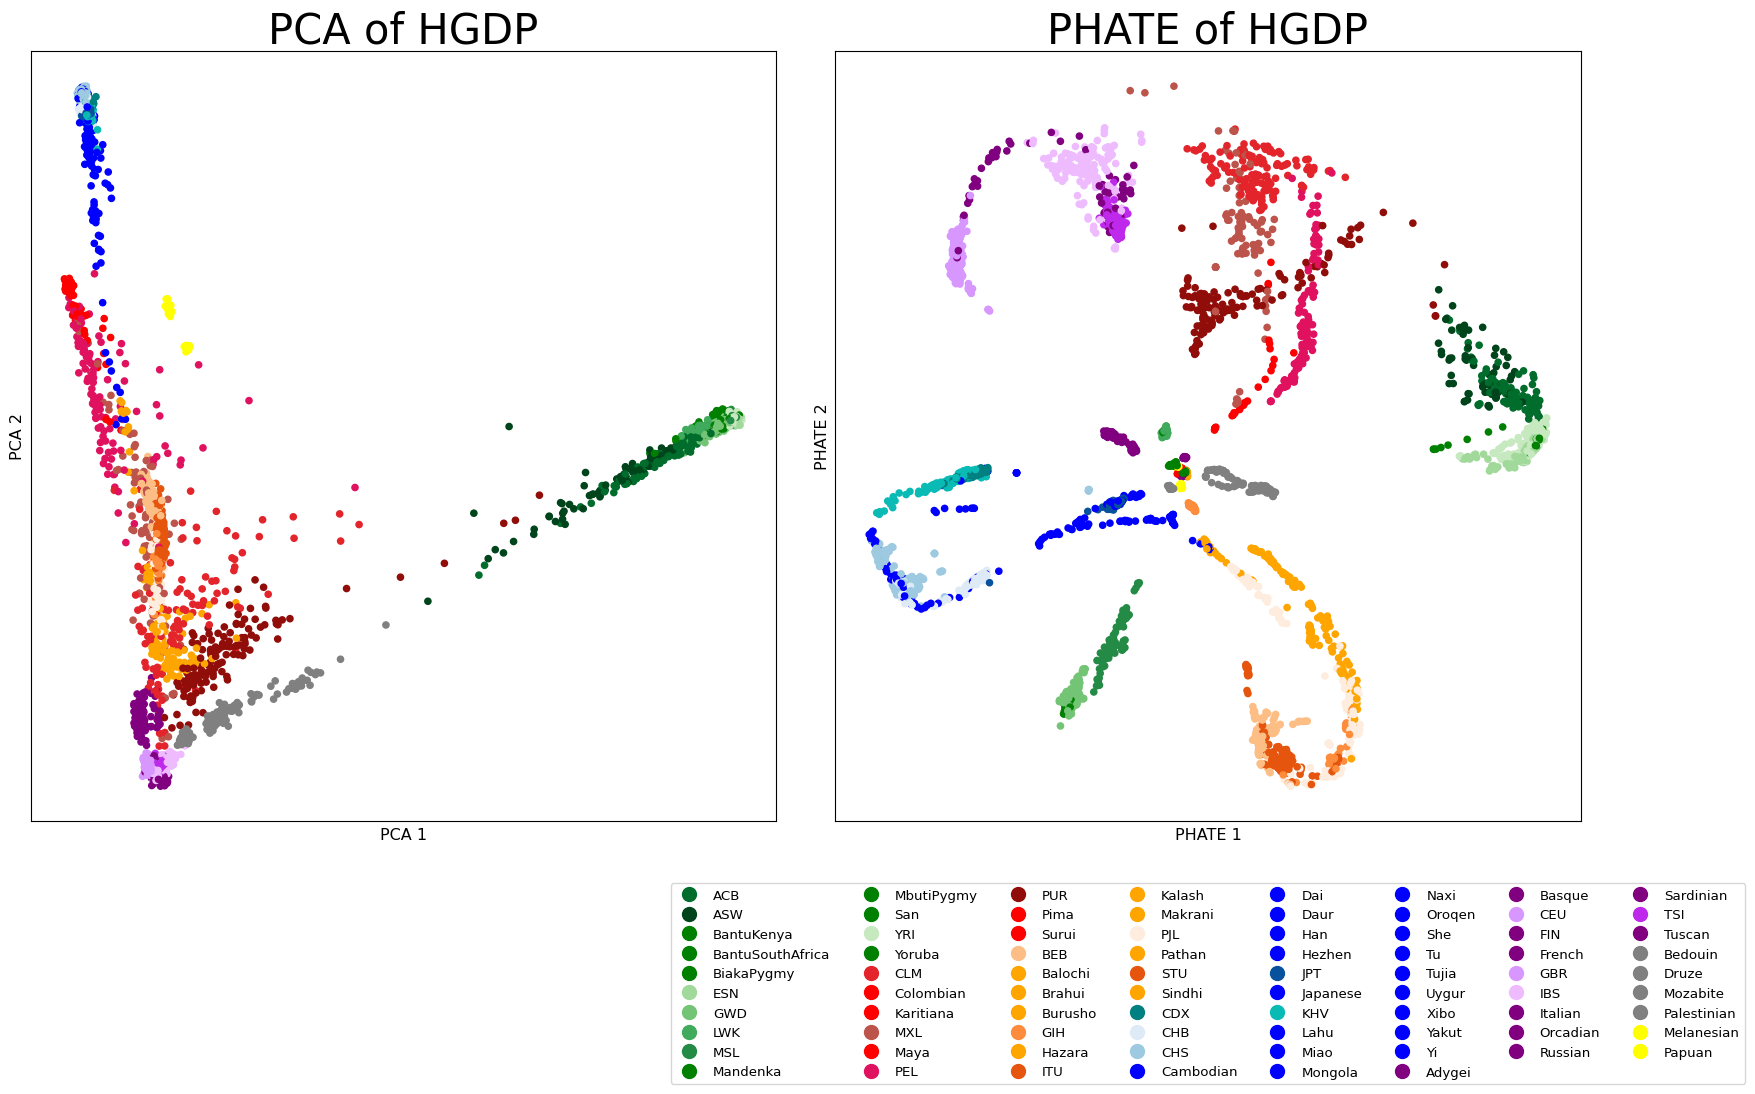

In [17]:
compute_pca_phate_subset(filtered_indices, related_indices, phate_fit_related=True)

## Correct for Related Points

In [18]:
filters = ["filter_pca_outlier", "hard_filtered", "filter_contaminated"]
_filtered_indices = merged_metadata[merged_metadata[filters].any(axis=1)].index
filtered_indices = ~merged_metadata.index.isin(_filtered_indices)
related_indices = ~merged_metadata['filter_king_related'].values

Running PHATE on 4094 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.35 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.37 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.18 seconds.
  Calculating KMeans...
  Calculated KMeans in 7.28 seconds.
Calculated landmark operator in 8.20 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.97 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.11 seconds.


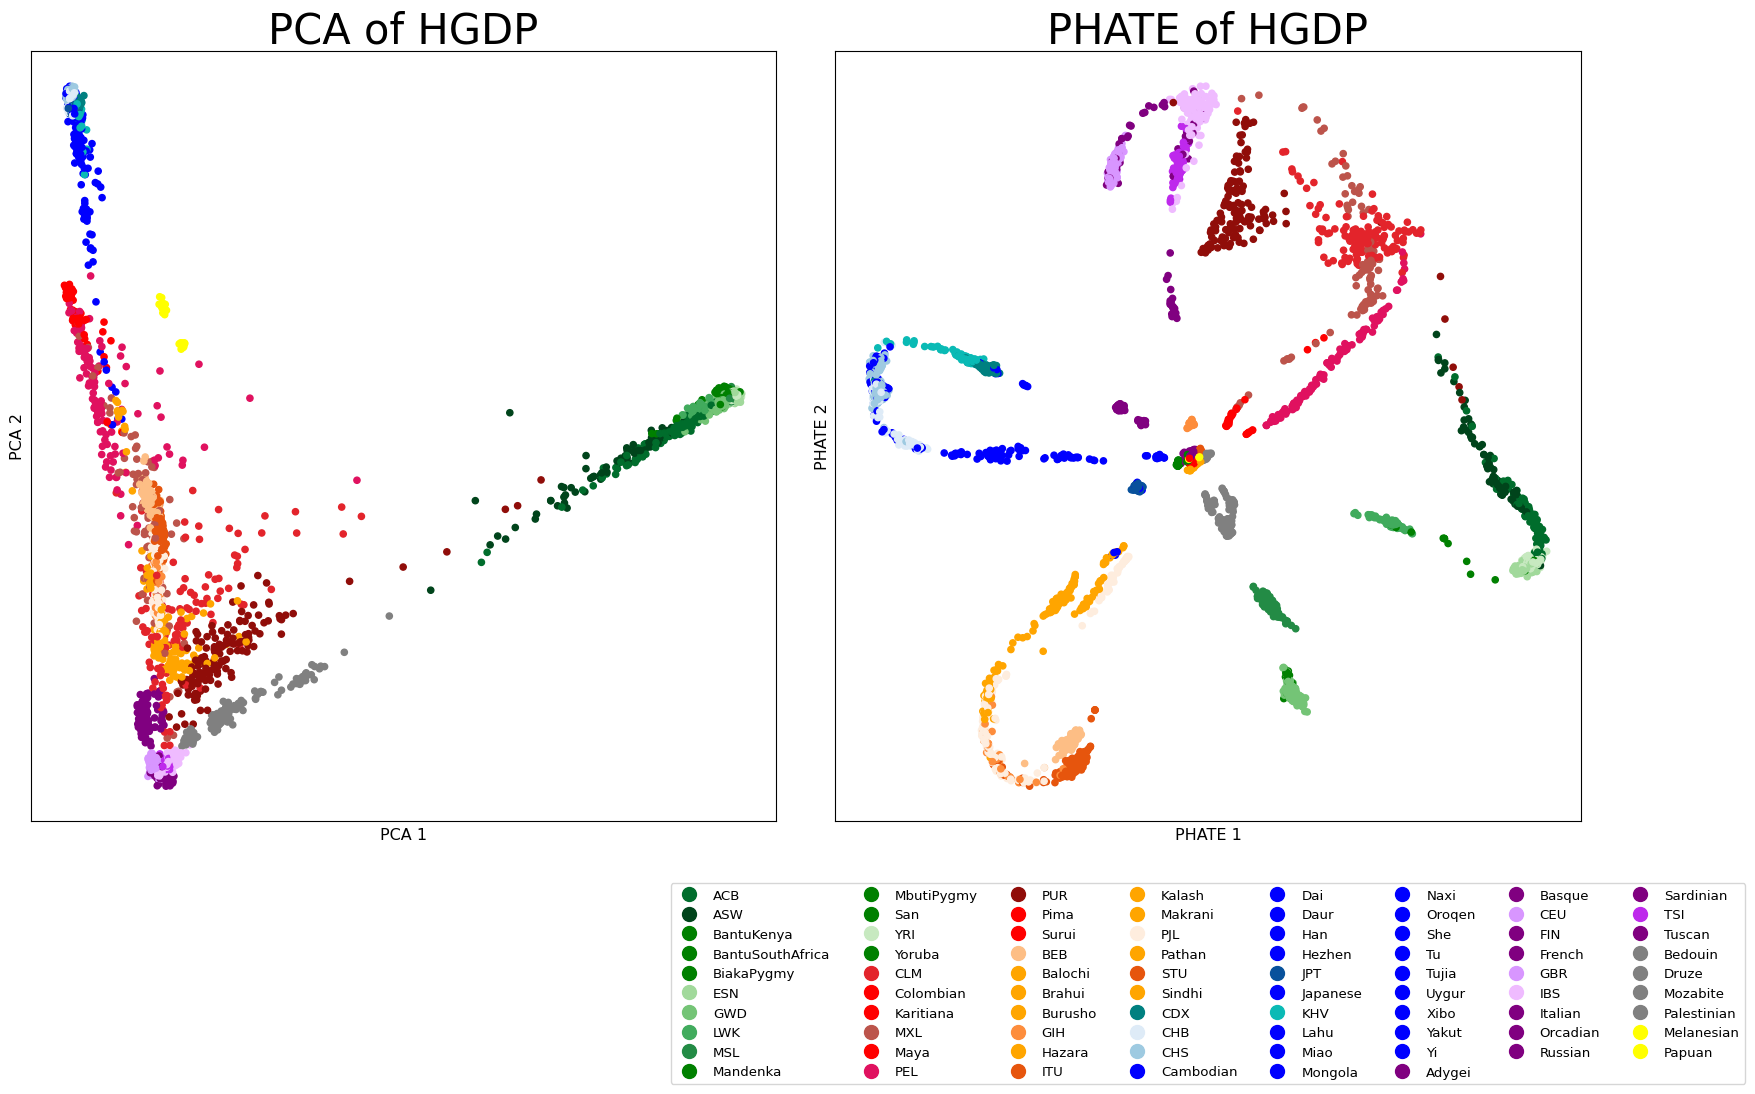

In [19]:
compute_pca_phate_subset(filtered_indices, related_indices, phate_fit_related=True)

### For PHATE, dont fit on related points.

Running PHATE on 3400 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.27 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.29 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.14 seconds.
  Calculating KMeans...
  Calculated KMeans in 4.44 seconds.
Calculated landmark operator in 5.28 seconds.
Calculating diffusion potential...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated diffusion potential in 0.88 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.81 seconds.
Calculating KNN search...
Calculated KNN search in 0.31 seconds.
Calculating affinities...
Calculated affinities in 0.02 seconds.


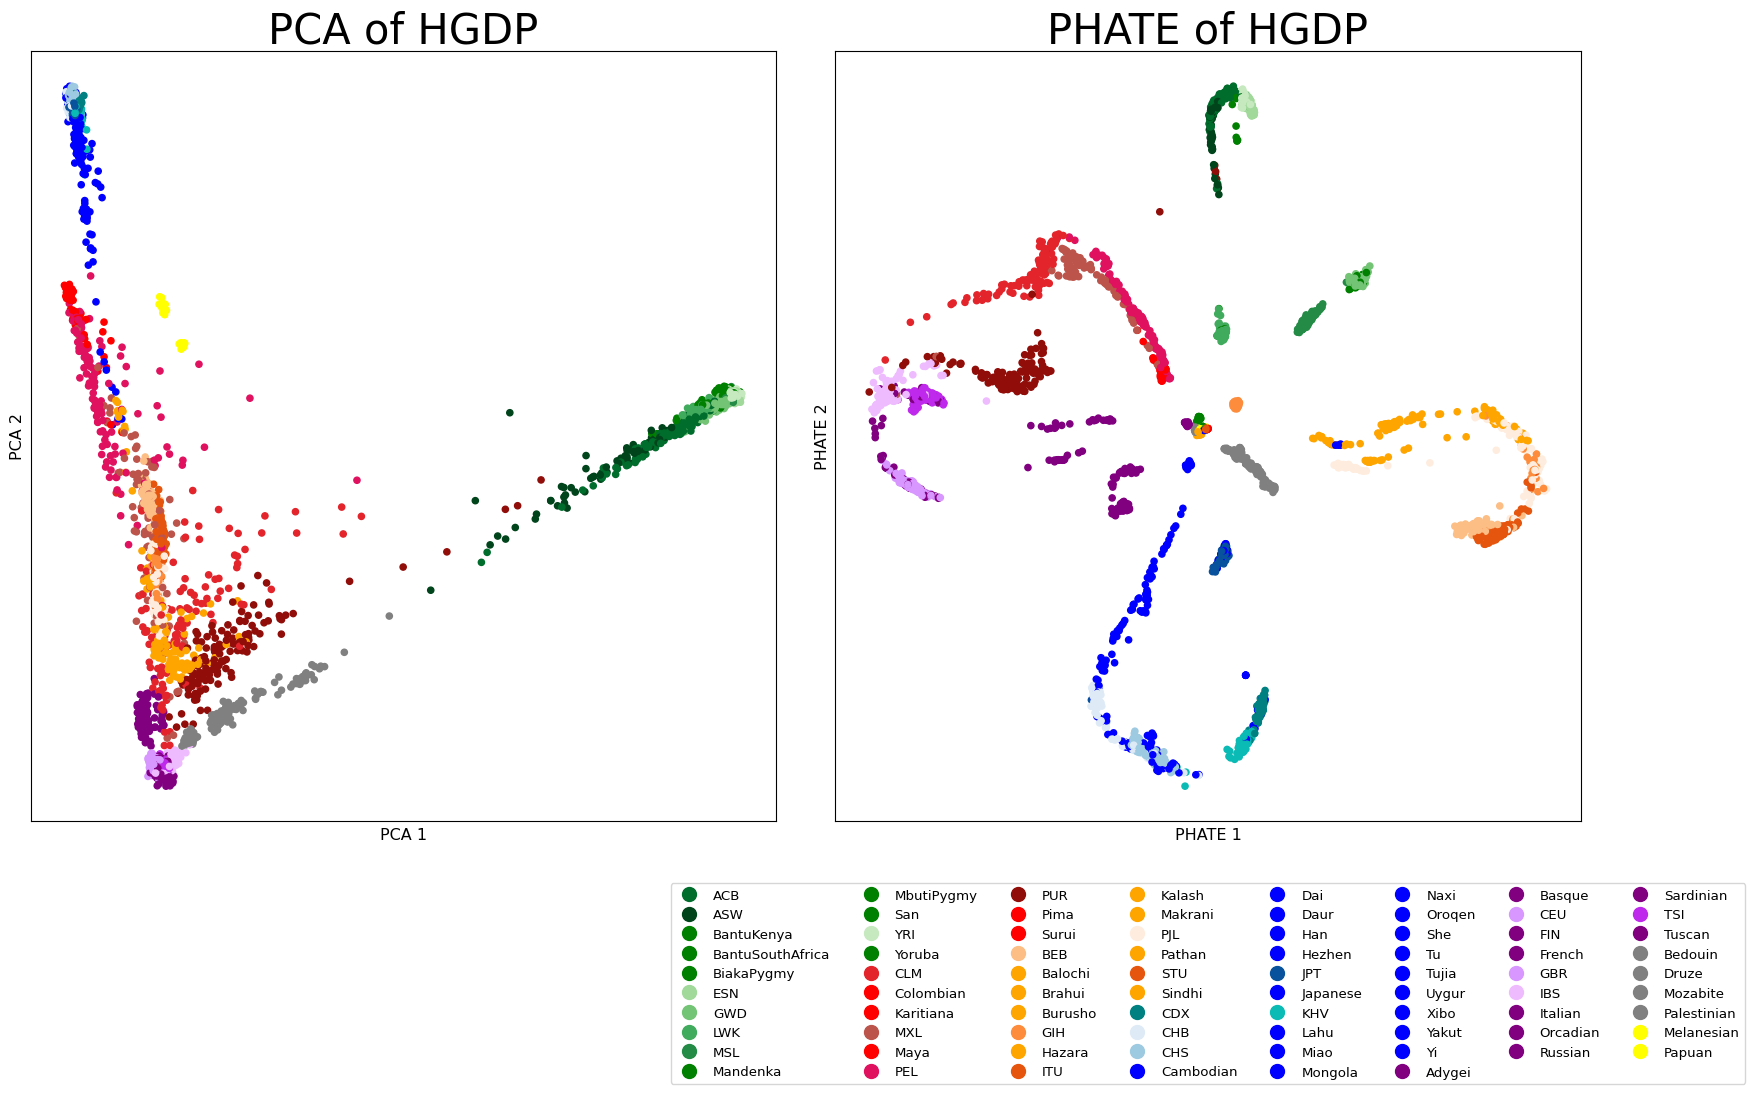

In [20]:
compute_pca_phate_subset(filtered_indices, related_indices, phate_fit_related=False)